In [1]:
%load_ext autoreload
%autoreload 2
%cd "python/LatentEvolution"
%ls

/home/hew/python/LatentEvolution
cache/  data/  env.txt  figure/  framework/  main.py  script/  temp/


In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from scipy.stats import pearsonr
from sklearn.manifold import TSNE

from framework.utils.lightning.trainer_utils import LitInference
from script.task_02_ProteinVAE.ProteinVAE.sequence_data_module import SequenceDataModule
from script.task_02_ProteinVAE.ProteinVAE.sequence_lightning_module import SequenceLightningModule

========== add root_path and framework_path to sys.path ==========
root_path: /home/hew/python/LatentEvolution
framework_path: /home/hew/python/LatentEvolution/framework


In [3]:
log_dir = "./script/task_02_ProteinVAE/lightning_logs/"

# WAE
version = 0
epoch = '88, loss=35.912, ce=18.633, reg=10.772, mse=6.506, ddG=0.531, dS=0.832.ckpt'

In [4]:
inferencer = LitInference(SequenceLightningModule, SequenceDataModule, log_dir, version, epoch)
inferencer.set_batch_size(128)
tokenizer = inferencer.pl_data_module.tokenizer
model = inferencer.model.eval()
model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42


============================== PeptideDataModule __init__ Start ==============================
============================== PeptideDataModule __init__ End ==============================


ProteinVAE(
  (encoder_transformer): ESMTransformer(
    (embed_tokens): Embedding(33, 128, padding_idx=1)
    (layers): ModuleList(
      (0-3): 4 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (rot_emb): RotaryEmbedding()
        )
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (final_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
    (emb_layer_norm_after): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (encoder_mlp): MLP(
    (mlp): Sequential(

In [5]:
def decode_latent_embeddings(z):
    logits = model.decode(z)[:, 1:-1]
    tokens = torch.argmax(logits, dim=-1)
    sequences = tokenizer.decode(tokens)
    return sequences

In [6]:
predictions = inferencer.predict('test')
predictions

============================== prepare_data: mode[predict] Start ==============================
prepare_data predict_data kwargs {'predict_data': 'test'}
============================== prepare_data: mode[test] Start ==============================
============================== prepare_dataset Start ==============================
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< load data according to selected index >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/2404 [00:00<?, ?it/s]

the dataset has not been partitioned, split dataset with specific ratio


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


dataframe partition values:
partition
train    1661
test      521
valid     222
Name: count, dtype: int64
select the subset for debug, max_len: 83, ratio: 1, number: 2404
============================== prepare_dataset End ==============================
len(self.test_dataset) 521
============================== prepare_data mode[test] End ==============================
len(self.predict_index) 521
============================== prepare_data mode[predict] End ==============================
============================== Setup [test] Start ==============================
[len self.predict_dataset] 521
============================== Setup [test] End ==============================


Predicting: 0it [00:00, ?it/s]

[{'recon_tokens': tensor([[ 8, 11, 12,  ...,  5,  4, 16],
          [ 6, 11, 12,  ...,  5,  4, 16],
          [ 8,  8, 12,  ...,  5,  4, 16],
          ...,
          [ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ...,  5,  4, 16]]),
  'tokens': tensor([[ 8, 11, 12,  ...,  5,  4, 16],
          [ 5, 11, 12,  ...,  5,  4, 16],
          [ 8,  8, 12,  ...,  5,  4, 16],
          ...,
          [ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ...,  5,  4, 16],
          [ 8, 11, 12,  ...,  5,  4, 16]]),
  'ddG': tensor([-7.3060e-01, -7.6810e-01, -1.3282e+00, -1.6700e-02, -1.2203e+00,
          -7.6630e-01, -1.8396e+00, -1.4710e-01, -1.4540e-01, -8.5610e-01,
          -1.4395e+00, -1.9383e+00, -5.6850e-01, -4.3980e-01, -1.1382e+00,
          -4.4631e+00, -1.3262e+00, -7.3980e-01, -1.0461e+00, -1.7806e+00,
          -8.5540e-01, -1.4865e+00, -1.5717e+00, -1.6680e-01, -1.2113e+00,
          -2.7900e-02, -1.8086e+00, -1.5696e+00, -1.81

In [7]:
true_tokens = torch.concat([batch['tokens'] for batch in predictions])
recon_tokens = torch.concat([batch['recon_tokens'] for batch in predictions])
predict_z = torch.concat([batch['z'] for batch in predictions])
predict_mean = torch.concat([batch['mean'] for batch in predictions])
predict_logvar = torch.concat([batch['logvar'] for batch in predictions])
predict_ddG = torch.concat([batch['pred_ddG'] for batch in predictions])
predict_dS = torch.concat([batch['pred_dS'] for batch in predictions])
true_ddG = torch.concat([batch['ddG'] for batch in predictions])
true_dS = torch.concat([batch['dS'] for batch in predictions])

sample_z = predict_mean + torch.randn_like(predict_logvar) * torch.exp(0.5 * predict_logvar)

In [8]:
pearsonr(predict_ddG, true_ddG)[0], pearsonr(predict_dS, true_dS)[0]

(0.5067621742678847, 0.8133953925645634)

In [9]:
predict_mean[:5, 0], predict_logvar[:5, 0], predict_z[:5, 0], sample_z[:5, 0]

(tensor([-1.3207, -1.2743, -0.6268, -1.4130,  0.7270]),
 tensor([ 0.1616,  2.9854,  0.6226,  1.0672, -4.0203]),
 tensor([-1.3207, -1.2743, -0.6268, -1.4130,  0.7270]),
 tensor([-0.5852, -4.9441, -0.6385, -3.6627,  0.8229]))

In [10]:
sample_z, decode_latent_embeddings(sample_z[:5])


100%|██████████| 5/5 [00:00<00:00, 3354.37it/s]


(tensor([[-0.5852, -1.9159, -3.1582,  ...,  1.0809,  1.1252, -2.5382],
         [-4.9441, -0.4684, -3.3056,  ..., -5.7708,  3.5721, -3.9957],
         [-0.6385, -0.2162, -1.3614,  ...,  0.6181,  0.8920, -1.1286],
         ...,
         [ 1.0947, -1.3661, -3.3294,  ..., -1.1277,  1.0614, -0.0201],
         [-2.7089, -0.6955, -4.4072,  ...,  0.9026,  2.4166, -1.6864],
         [-1.1956, -0.7076, -4.4249,  ...,  4.7514,  1.3743, -0.8497]]),
 ['SPIFEQIAVTNAAAIINASQNNLQSSVGSQSSSPNNGENQNNAPNGAASIISAASIIAVANPSSPPAQIQQQATAIQVQAQQQ',
  'ITIANQTASAAYTQYAYEEQNYYQQQLNWQYNNTYSKYENNYNYNNAYQKSSAAYYQQSADYQQRPLQQQAQATYQQQQYYYQ',
  'SSRLAQAGPNNNAINIANIDQIAQSLDAAWNNNGNQTEEYQQAGDEAQQAWSAFQANQSTLQQGYPLQQGQRNQDAGNAQQKD',
  'EMPNEQAQATNMMVQQEWEQWAQQTQSSQTTNNTYTIQENLQNWVQAEAAASYSATAWMQAGQMMQIQEMQQAVEEMQQQWEQ',
  'QSEIGQATYPLVTKNRLFFQQFYQSAAASTNYNTAPNENNNPNAENAGAMASIIAQDQSTAAQQYQLQLMQQLPKKQQLQYVQ'])

In [11]:
predict_z, decode_latent_embeddings(predict_z[:5])


100%|██████████| 5/5 [00:00<00:00, 3987.74it/s]


(tensor([[-1.3207, -0.6753, -3.1082,  ...,  1.3889,  0.5763, -0.1030],
         [-1.2743, -0.5038, -3.2627,  ..., -5.1255,  4.7469, -5.7353],
         [-0.6268, -0.2448, -1.0492,  ...,  0.2183,  1.4485, -0.9779],
         ...,
         [-0.8434, -0.5441, -2.5315,  ...,  0.9693,  0.8962, -0.1992],
         [-1.2804, -0.8464, -3.4977,  ..., -0.8580,  2.4474, -1.8492],
         [-1.1543, -0.6679, -3.6206,  ...,  0.0173,  1.2523, -0.8174]]),
 ['STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIENLTVKLQLQALQ',
  'GTIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVENMNNAGDKWSAFLKEQSTLAQMYNLQEIQNLTVKLQLQALQ',
  'SSIEEQAKKFLDKFNHEAEDLFYQSSLASWDYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMMNAGDKWSEFMKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'DNIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVANMNNAGDKWSAFLKEMSTLAQMYPLYEIQNLTVKLQLQALQ'])

In [12]:
predict_mean, decode_latent_embeddings(predict_mean[:5])


100%|██████████| 5/5 [00:00<00:00, 4837.72it/s]


(tensor([[-1.3207, -0.6753, -3.1082,  ...,  1.3889,  0.5763, -0.1030],
         [-1.2743, -0.5038, -3.2627,  ..., -5.1255,  4.7469, -5.7353],
         [-0.6268, -0.2448, -1.0492,  ...,  0.2183,  1.4485, -0.9779],
         ...,
         [-0.8434, -0.5441, -2.5315,  ...,  0.9693,  0.8962, -0.1992],
         [-1.2804, -0.8464, -3.4977,  ..., -0.8580,  2.4474, -1.8492],
         [-1.1543, -0.6679, -3.6206,  ...,  0.0173,  1.2523, -0.8174]]),
 ['STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIENLTVKLQLQALQ',
  'GTIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVENMNNAGDKWSAFLKEQSTLAQMYNLQEIQNLTVKLQLQALQ',
  'SSIEEQAKKFLDKFNHEAEDLFYQSSLASWDYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMMNAGDKWSEFMKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'DNIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVANMNNAGDKWSAFLKEMSTLAQMYPLYEIQNLTVKLQLQALQ'])

In [13]:
recon_sequences = tokenizer.decode(recon_tokens[:5])
recon_sequences


100%|██████████| 5/5 [00:00<00:00, 4165.15it/s]


['STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIENLTVKLQLQALQ',
 'GTIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVENMNNAGDKWSAFLKEQSTLAQMYNLQEIQNLTVKLQLQALQ',
 'SSIEEQAKKFLDKFNHEAEDLFYQSSLASWDYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMMNAGDKWSEFMKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'DNIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVANMNNAGDKWSAFLKEMSTLAQMYPLYEIQNLTVKLQLQALQ']

In [14]:
set(recon_sequences)

{'DNIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVANMNNAGDKWSAFLKEMSTLAQMYPLYEIQNLTVKLQLQALQ',
 'GTIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVENMNNAGDKWSAFLKEQSTLAQMYNLQEIQNLTVKLQLQALQ',
 'SSIEEQAKKFLDKFNHEAEDLFYQSSLASWDYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIENLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMMNAGDKWSEFMKEQSTLAQMYPLQEIQNLTVKLQLQALQ'}

In [15]:
true_sequences = tokenizer.decode(true_tokens[:5])
true_sequences


100%|██████████| 5/5 [00:00<00:00, 4396.55it/s]


['STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIENLTVKLQLQALQ',
 'ATIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVENMNNYGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'SSIEEQAKKFLDKFNHEAEDLFYQSSLASWDYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMMNAGDKWSEFWKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'DQIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVYNMNNAGDKWSAFLKEMSTLAQMYPLEEIQNLTVKLQLQALQ']

In [16]:
recon_sequences == decode_latent_embeddings(predict_z[:5])


100%|██████████| 5/5 [00:00<00:00, 5103.80it/s]


True

In [17]:
for seq1, seq2 in zip(recon_sequences, true_sequences):
    print(seq1 == seq2)

True
False
True
False
False


In [18]:
true_tokens[0]

tensor([ 8, 11, 12,  9,  9, 16,  5, 15, 11, 18,  4, 13, 15, 18, 17, 21,  9,  5,
         9, 13,  4, 18, 19, 16,  8,  8,  4,  5, 15, 22, 17, 19, 17, 11, 17, 12,
        11,  9,  9, 17,  7, 16, 17, 20, 17, 17,  5,  6, 13, 15, 22,  8,  5, 18,
         4, 15,  9, 16,  8, 11,  4,  5, 16, 20, 19, 14,  4, 16,  9, 12,  9, 17,
         4, 11,  7, 15,  4, 16,  4, 16,  5,  4, 16])

In [19]:
recon_tokens[0]

tensor([ 8, 11, 12,  9,  9, 16,  5, 15, 11, 18,  4, 13, 15, 18, 17, 21,  9,  5,
         9, 13,  4, 18, 19, 16,  8,  8,  4,  5, 15, 22, 17, 19, 17, 11, 17, 12,
        11,  9,  9, 17,  7, 16, 17, 20, 17, 17,  5,  6, 13, 15, 22,  8,  5, 18,
         4, 15,  9, 16,  8, 11,  4,  5, 16, 20, 19, 14,  4, 16,  9, 12,  9, 17,
         4, 11,  7, 15,  4, 16,  4, 16,  5,  4, 16])

In [20]:
sample_error_rate = torch.sum(~(true_tokens[0] == recon_tokens[0])) / len(true_tokens[0])
average_error_rate = torch.sum(~(true_tokens == recon_tokens)) / len(true_tokens[0]) / len(true_tokens)
average_error_num = average_error_rate * len(true_tokens[0])
sample_error_rate, average_error_rate, average_error_num, len(true_tokens)

(tensor(0.), tensor(0.0240), tensor(1.9923), 521)

In [21]:
data_df = pd.read_csv('./data/ACE2_variants/cooked/ACE2_variants.csv')
data_df

,index,name,partition,length,sequence,structure,graph,ddG,dS
0,0,0,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,0.4875,0.000
1,1,1,NaN,83,STIELQAKDFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,1.6714,-0.063
2,10,10,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENIQNMNN...,NaN,NaN,-0.7219,0.000
3,100,100,NaN,83,STIEEQAKTFLDKFNFEAEDLFYQSSQASWNYNTNITEENVQNMNN...,NaN,NaN,3.1538,0.043
4,1000,1000,NaN,83,STWEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENDQNMNN...,NaN,NaN,3.6520,0.017
...,...,...,...,...,...,...,...,...,...
126207,99995,99995,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNP...,NaN,NaN,3.7586,0.000
126208,99996,99996,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,0.9857,0.017
126209,99997,99997,NaN,83,STNEEQAKTFLDKFNHEAEWLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,3.0270,-0.051
126210,99998,99998,NaN,83,SDMEEIAKTFLDKFNHEAEDLFYQSSLASWEYNTNITEENVKNMNN...,NaN,NaN,-2.9044,0.017


In [22]:
true_sequences = tokenizer.decode(true_tokens)
data_df = data_df[data_df['sequence'].isin(true_sequences)]
data_df


100%|██████████| 521/521 [00:00<00:00, 7352.51it/s]


,index,name,partition,length,sequence,structure,graph,ddG,dS
9281,10835,10835,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENVQNMNN...,NaN,NaN,-0.7306,0.017
12551,111292,111292,NaN,83,ATIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVENMNN...,NaN,NaN,-0.7681,0.017
12822,111536,111536,NaN,83,SSIEEQAKKFLDKFNHEAEDLFYQSSLASWDYNTNITEENVQNMNN...,NaN,NaN,-1.3282,0.017
15976,114375,114375,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMMN...,NaN,NaN,-0.0167,0.017
17787,116004,116004,NaN,83,DQIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVYNMNN...,NaN,NaN,-1.2203,0.017
...,...,...,...,...,...,...,...,...,...
74728,53662,53662,NaN,83,SDIEEQAKTFLDKFNHEAEDLFYQSSLESWNYNTNITEENVQNMNN...,NaN,NaN,-1.8427,0.017
75514,5437,5437,NaN,83,SDIEEQAKTFLDKFNHEAEDLFYQHSLASWNYNTNITEENVQNMNN...,NaN,NaN,-1.6818,0.005
76136,5493,5493,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLAFWNYNTNITEENVQEMNN...,NaN,NaN,-1.7093,0.017
76292,5507,5507,NaN,83,DTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,-0.2346,0.017


In [23]:
prediction_data = {
    'true_tokens': true_tokens,
    'recon_tokens': recon_tokens,
    'predict_z': predict_z,
    'predict_mean': predict_mean,
    'predict_logvar': predict_logvar,
    'true_sequences': true_sequences,
    'ddG': data_df.ddG.to_numpy(),
    'dS': data_df.dS.to_numpy()
}

diffusion_model_train_data = {
    'mean': predict_mean,
    'z': predict_z,
    'ddG': data_df.ddG.to_numpy(),
    'dS': data_df.dS.to_numpy()
}

In [24]:
%%time
save_file = f'./script/task_03_Latent_analysis/version_{version}_prediction_data.pt'
if not os.path.exists(save_file):
    torch.save(prediction_data, save_file)

CPU times: user 10.9 ms, sys: 4.49 ms, total: 15.4 ms
Wall time: 15.3 ms


In [25]:
%%time
save_file = f'./script/task_04_LatentRegression/version_{version}_train_data.pt'
if not os.path.exists(save_file):
    torch.save(diffusion_model_train_data, save_file)

CPU times: user 1.16 ms, sys: 7.58 ms, total: 8.75 ms
Wall time: 8.68 ms


In [27]:
version = 0
save_file = f'./script/task_03_Latent_analysis/version_{version}_prediction_data.pt'
load_prediction_data = torch.load(save_file)
true_tokens = load_prediction_data['true_tokens']
recon_tokens = load_prediction_data['recon_tokens']
predict_z = load_prediction_data['predict_z']
predict_mean = load_prediction_data['predict_mean']
predict_logvar = load_prediction_data['predict_logvar']
true_sequences = load_prediction_data['true_sequences']
ddG = load_prediction_data['ddG']
dS = load_prediction_data['dS']

In [28]:
flags = []
for i in range(len(true_sequences[0])):
    flag = (recon_tokens[:, i] == recon_tokens[0, i]).all()
    flags.append(flag)
flags = torch.tensor(flags)
flags.all()

tensor(False)

In [29]:
recon_sequences = tokenizer.decode(recon_tokens)
set(recon_sequences), len(set(recon_sequences))


100%|██████████| 521/521 [00:00<00:00, 7080.79it/s]


({'ADIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNVAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALK',
  'ATIEEQAKTFLDKFNHEAEDLFYQSSFANWNYNTNITEENVQNMNNAGDKWIAFLKEQSTLAQMYPLQEIQNLTVKLQLQALK',
  'ATIEEQAKTFLDKFNHEAEDLFYQVSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNWTVKLQLQALQ',
  'DNIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVANMNNAGDKWSAFLKEMSTLAQMYPLYEIQNLTVKLQLQALQ',
  'DTIEEQAKIFLDKFNHEAEDLFYQLSLASWRYNTNITEENVVNMNNAGDKASAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'DTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSLLAQMYPLQEIQNLTVKLQLQALQ',
  'DTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAWDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'DTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQYMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'DTMEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAMDKWSAFLKEQSTLAQMYPLQEIQNLVVKLQLQALQ',
  'DTMEEQAKTMLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLWALQ',
  'DYIEEQAKTFLDKFNHEAEDLFYYSSLASWNYNTNITEENVQAMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'ETIEEQAETFLDKFNHEA

In [30]:
pearsonr(predict_z[:10000].reshape(-1).cpu().numpy(), predict_mean[:10000].reshape(-1).cpu().numpy())[0]

1.0

In [31]:
predict_z.shape, predict_mean.shape

(torch.Size([521, 1360]), torch.Size([521, 1360]))

In [32]:
%%time
if predict_z.shape[1] > 2:
    print('T-SNE')
    tsne = TSNE(n_components=2, random_state=0)
    z_tsne = tsne.fit_transform(predict_z.cpu().numpy())
    z_tsne = pd.DataFrame(z_tsne, columns=['x', 'y'])
else:
    z_tsne = pd.DataFrame(predict_z, columns=['x', 'y'])

z_tsne['ddG'] = ddG
z_tsne['dS'] = dS
z_tsne['true_sequences'] = true_sequences
z_tsne

T-SNE
CPU times: user 25.8 s, sys: 1.19 s, total: 27 s
Wall time: 1.09 s


,x,y,ddG,dS,true_sequences
0,13.544807,14.507022,-0.7306,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENVQNMNN...
1,-0.400749,11.097868,-0.7681,0.017,ATIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVENMNN...
2,9.191717,14.122949,-1.3282,0.017,SSIEEQAKKFLDKFNHEAEDLFYQSSLASWDYNTNITEENVQNMNN...
3,-9.441395,8.905304,-0.0167,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMMN...
4,2.430802,-21.219425,-1.2203,0.017,DQIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVYNMNN...
...,...,...,...,...,...
516,19.571266,10.488268,-1.8427,0.017,STIEEQAKTFLDKFNHEAEDLFYQSDLARWNYNTNITEENVQNMNN...
517,10.131841,-0.841320,-1.6818,0.005,STIEEQAKTFLDKFNHEAEDLFYQSSLASWWYNTNITEENVQNMNN...
518,-5.104984,2.713130,-1.7093,0.017,STIEEQAKTFLDKFNHEAEDLFYQMSLASWNYNTNITEENVQNMNN...
519,-23.781042,0.233123,-0.2346,0.017,SDIEEQAKMFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...


In [33]:
z_tsne.to_csv(f'./script/task_03_Latent_analysis/version_{version}_z_tsne.csv', index=False)

In [34]:
z_tsne_1 = z_tsne[z_tsne['ddG'] < -2]
z_tsne_1

,x,y,ddG,dS,true_sequences
15,25.787817,6.500981,-4.4631,0.017,SDIEEQAKTFLDKFNHEAEDLFYQSSLAMWNYNTNITEENVQNMNN...
33,20.397400,-13.492746,-4.8645,0.017,SDIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
36,-14.396610,-13.076316,-2.4691,0.017,STIEEQAKTFLDKFNHEAEDLFYHSSLASWTYNTNITEENVQNMNN...
74,-16.292398,17.681797,-2.4631,0.017,STIEEQAKIFLDKFNHEAEDLFYQSSEASWNYNTNITEENVQNMNN...
83,-19.477591,-9.239684,-3.3720,0.005,SNIEEQAKTFLDKFAHEAEDLFYQHELASWNYNTNITEENVQNMNA...
93,-3.197682,6.503911,-3.3663,0.005,STIEEQAKDFLDKFNHEAEDLFYQFSLASWNYNTNITEENVQNMNS...
95,-14.970304,-15.086305,-2.3265,0.017,STIEEQAKTFLDKFEHEAEDLFYQSSLFSWNYNTNITEENVQNMNF...
96,19.738390,6.756872,-2.8241,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLAWWNYNTNITEENVVNMNN...
114,4.594073,-18.070940,-4.0275,0.017,STIEEQAKTFLDKFLHEAEDLWYQSSLASWNYNTNITEENVQNMNN...
121,18.360456,-15.434517,-2.2000,0.017,SDIEEQAKTFLDYFNHEAEDLFYQSKLASWNYNTNITEENVQNMNN...


In [35]:
z_tsne_2 = z_tsne[(-2 < z_tsne['ddG']) & (z_tsne['ddG'] < -1)]
z_tsne_2

,x,y,ddG,dS,true_sequences
2,9.191717,14.122949,-1.3282,0.017,SSIEEQAKKFLDKFNHEAEDLFYQSSLASWDYNTNITEENVQNMNN...
4,2.430802,-21.219425,-1.2203,0.017,DQIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVYNMNN...
6,22.076050,-15.700543,-1.8396,0.017,WDIEEQAKTFLDKFNHEAEDLFYLSSLASWNYNTNITEENVQWMNN...
9,16.721848,8.664961,-1.9383,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLAFWNYNTNITEENVQNMNN...
13,-7.512825,13.314568,-1.1382,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
...,...,...,...,...,...
513,6.056025,15.925699,-1.9267,0.017,SEIEEQAKTFLDKFNHKAEDLFYQSSLASWNYNTNITEENEQNMNN...
515,25.699429,10.924140,-1.3416,0.017,STIEEQAKTFLDKFEDEAEDLFYQQSLAMWNYNTNITEENVQNMNN...
516,19.571266,10.488268,-1.8427,0.017,STIEEQAKTFLDKFNHEAEDLFYQSDLARWNYNTNITEENVQNMNN...
517,10.131841,-0.841320,-1.6818,0.005,STIEEQAKTFLDKFNHEAEDLFYQSSLASWWYNTNITEENVQNMNN...


In [36]:
z_tsne_3 = z_tsne[(-1 < z_tsne['ddG']) & (z_tsne['ddG'] < 0)]
z_tsne_3

,x,y,ddG,dS,true_sequences
0,13.544807,14.507022,-0.7306,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENVQNMNN...
1,-0.400749,11.097868,-0.7681,0.017,ATIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVENMNN...
3,-9.441395,8.905304,-0.0167,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMMN...
5,20.363401,-0.923436,-0.7663,0.005,STLEEQAKDFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
7,-23.991262,-2.080458,-0.1471,0.017,SDIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
...,...,...,...,...,...
510,28.977087,8.086068,-0.7078,0.017,STWEEQAKTFLDKFNHEAEDLFYQSSLARWDMNTNITEENVQNMKN...
511,7.296398,-2.518724,-0.4275,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
514,13.593431,-2.606666,-0.5883,0.017,SEIEEQAKTFLDKFNHEAEDLKYQSSLASWNYNTNITEENVQKMNH...
519,-23.781042,0.233123,-0.2346,0.017,SDIEEQAKMFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...


In [37]:
z_tsne_4 = z_tsne[0 < z_tsne['ddG']]
z_tsne_4

,x,y,ddG,dS,true_sequences


CPU times: user 68 ms, sys: 16.5 ms, total: 84.4 ms
Wall time: 138 ms


/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x', ylabel='y'>

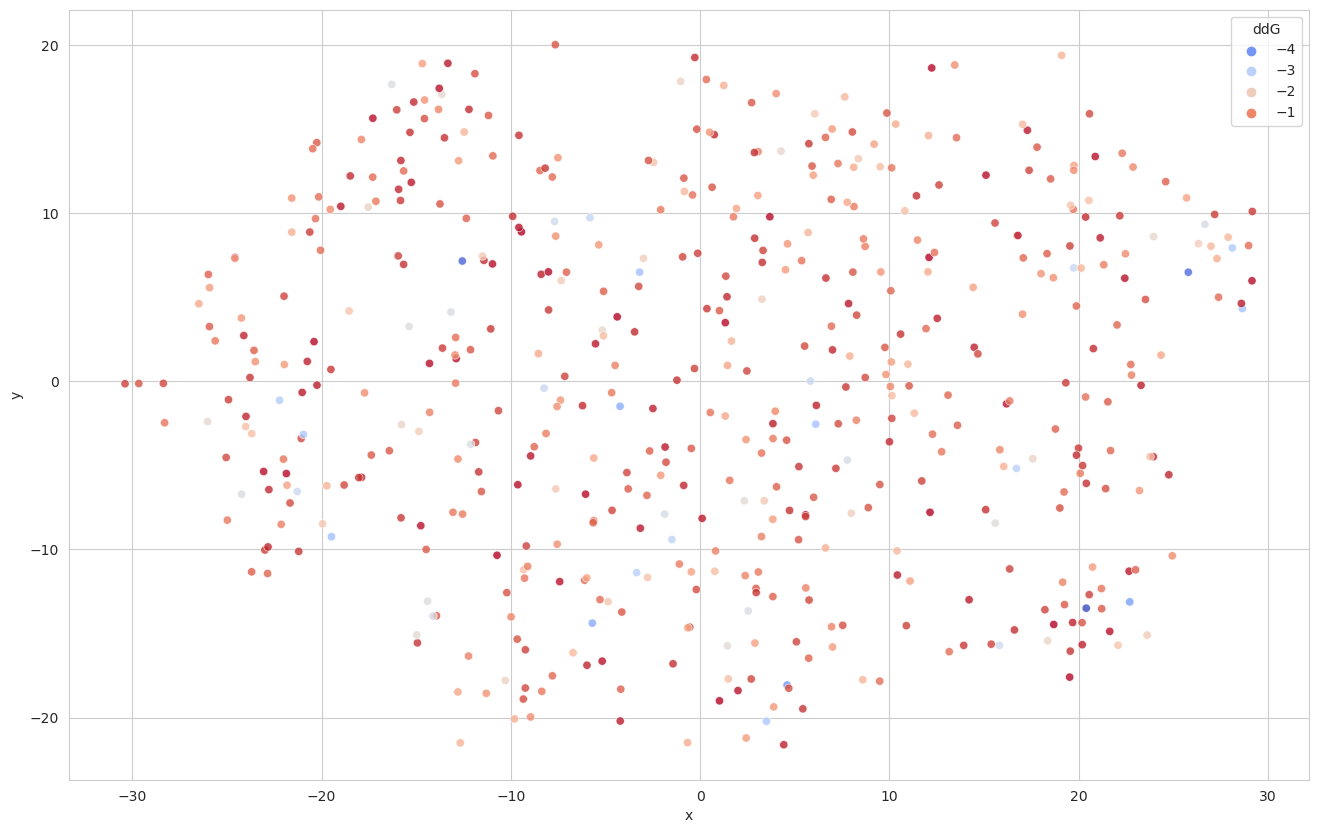

In [38]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm',
    data=z_tsne,
    alpha=0.8
)

CPU times: user 50.8 ms, sys: 0 ns, total: 50.8 ms
Wall time: 49.7 ms


/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x', ylabel='y'>

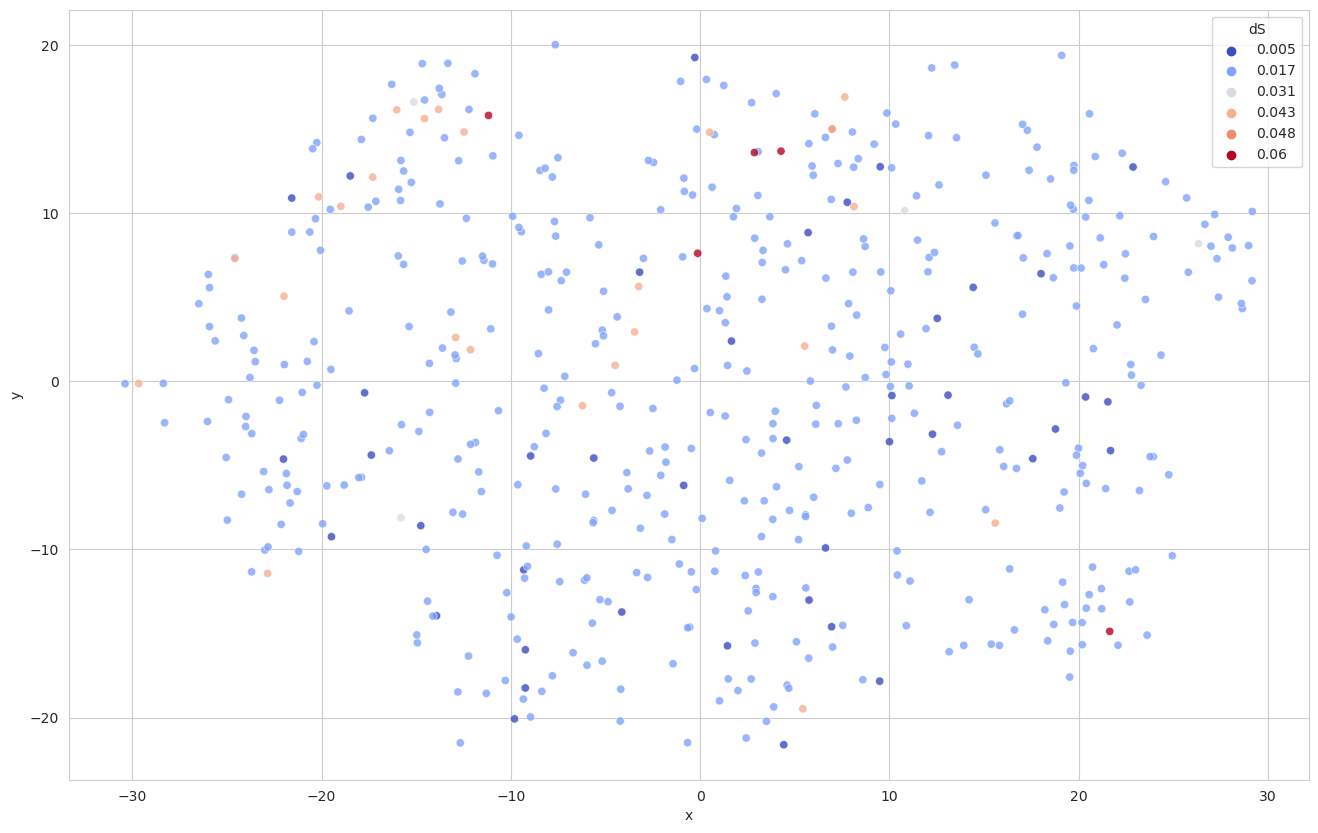

In [39]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="dS",
    palette='coolwarm',
    data=z_tsne,
    alpha=0.8
)

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 47 ms


/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x', ylabel='y'>

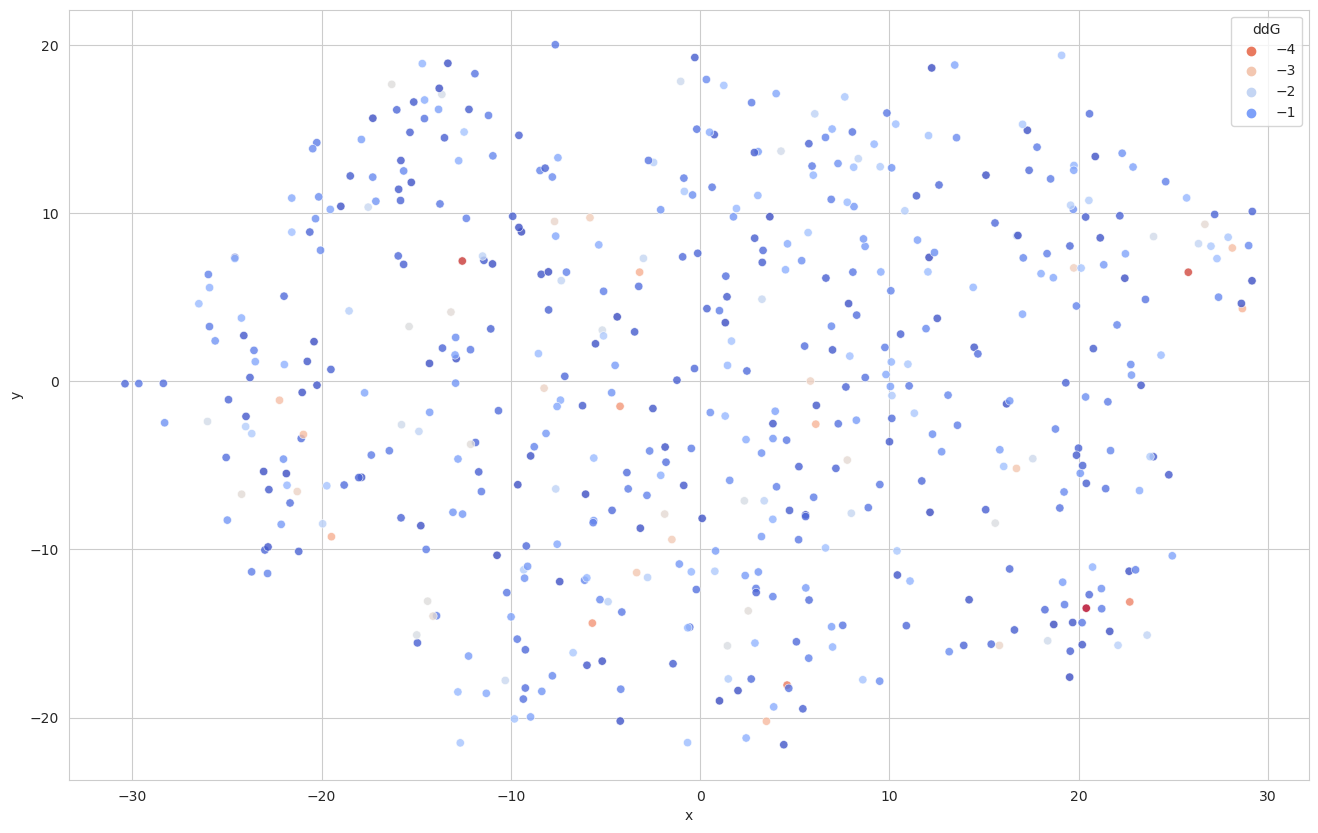

In [40]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm_r',
    data=z_tsne[0 > z_tsne['ddG']][:3000],
    alpha=0.8
)

CPU times: user 51 ms, sys: 299 µs, total: 51.3 ms
Wall time: 49.7 ms


/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x', ylabel='y'>

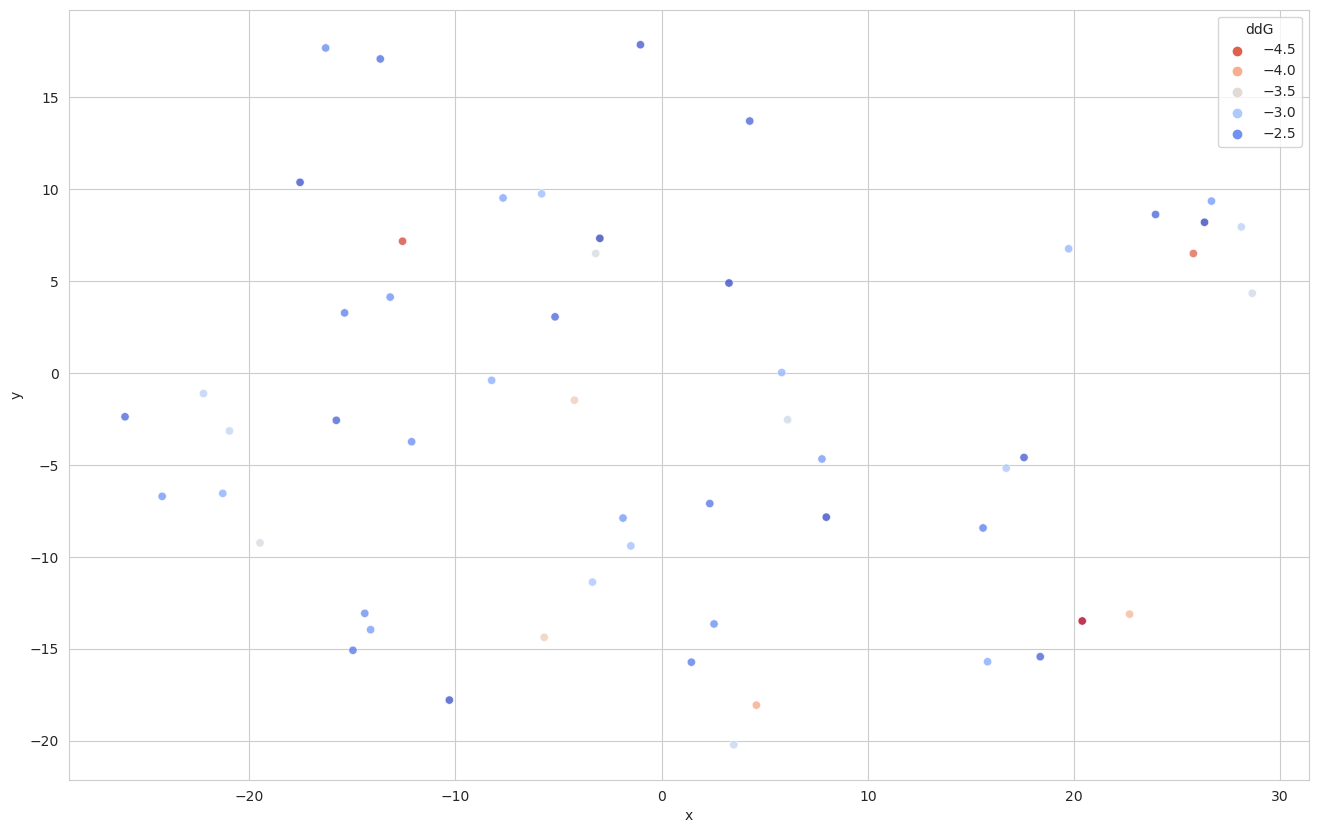

In [41]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm_r',
    data=z_tsne[-2 > z_tsne['ddG']][:3000],
    alpha=0.8
)

CPU times: user 54.3 ms, sys: 219 µs, total: 54.5 ms
Wall time: 52.9 ms


/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x', ylabel='y'>

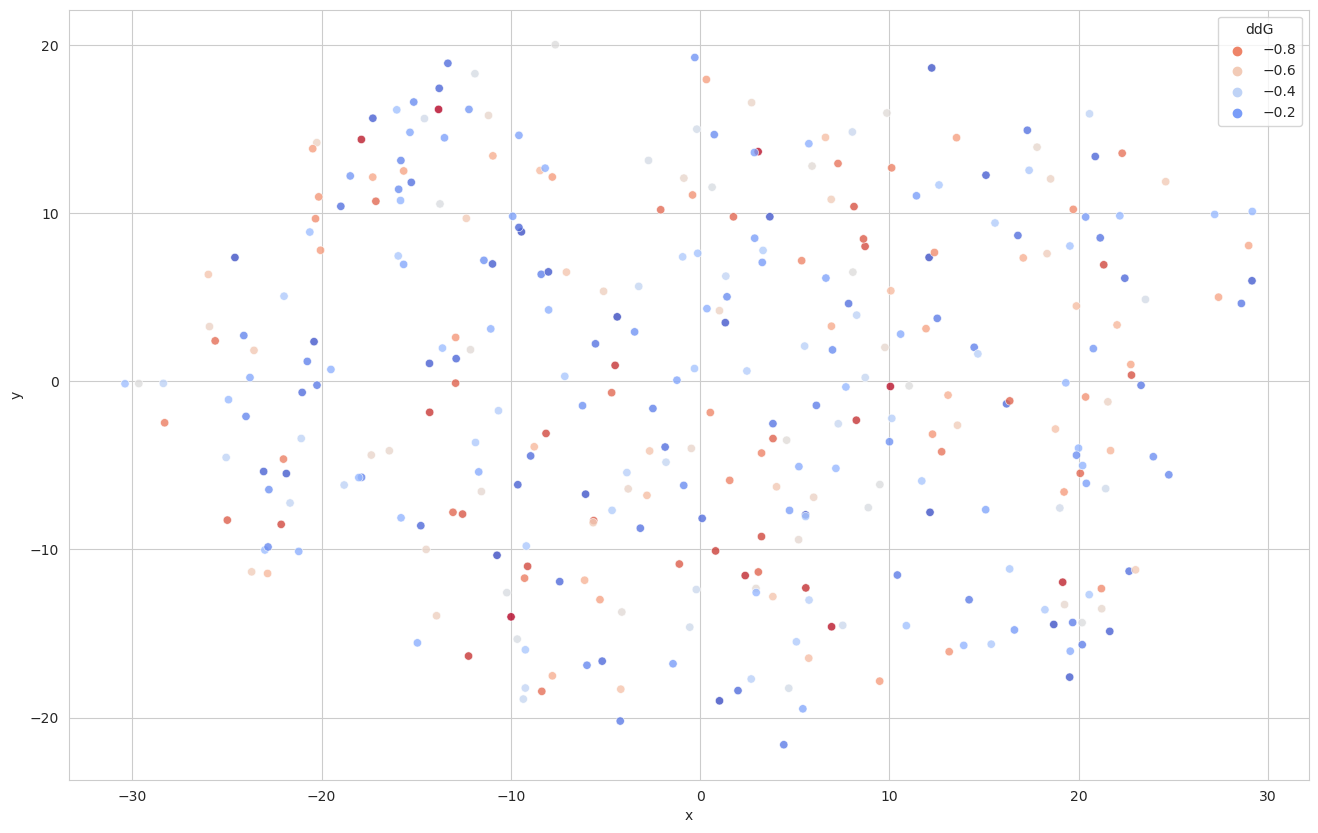

In [42]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm_r',
    data=z_tsne[(1 > z_tsne['ddG']) & (-1 < z_tsne['ddG'])][:3000],
    alpha=0.8
)

In [43]:
z_norm = predict_z.norm(dim=1)
z_ddG = ddG
z_dS = dS

/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hew/anaconda3/envs/deco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='z_ddG', ylabel='z_dS'>

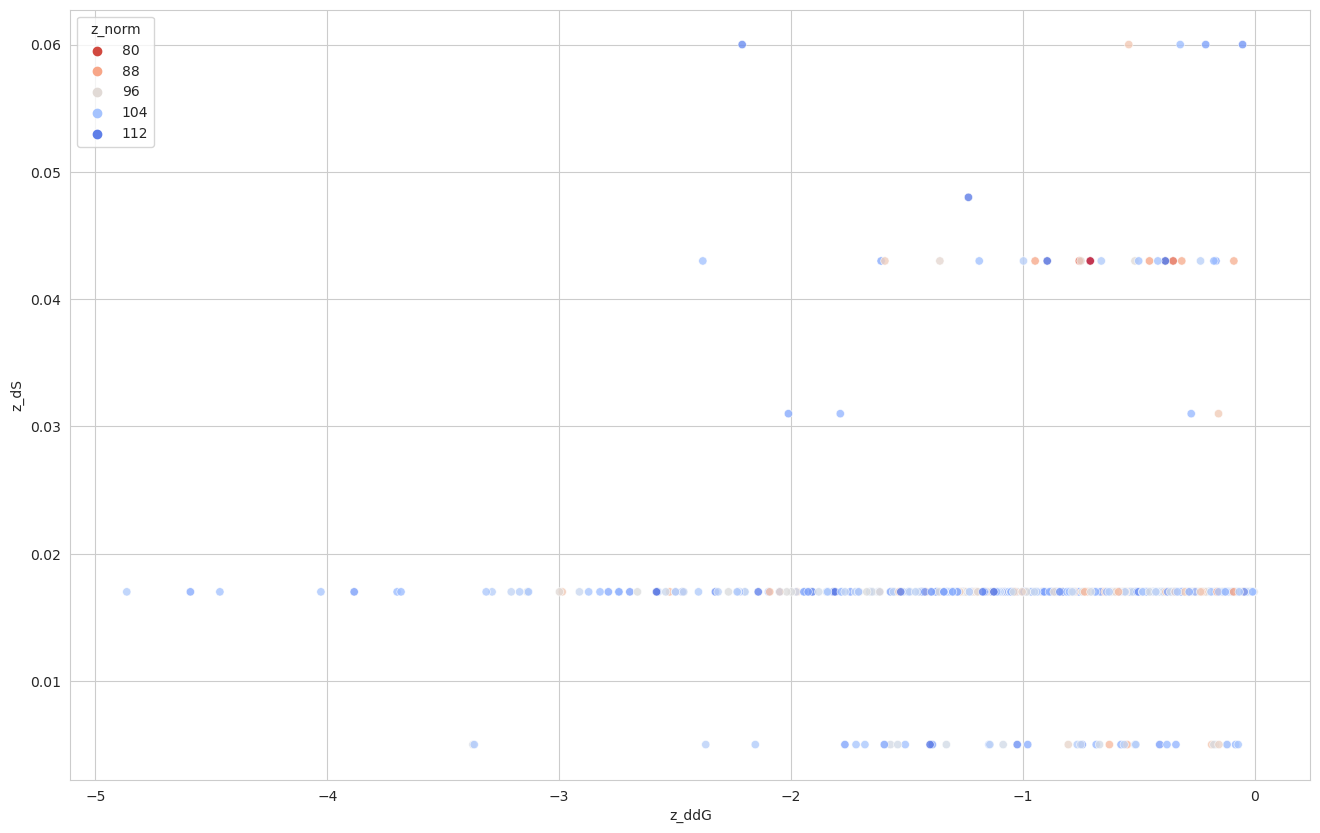

In [44]:
# 绘制z_norm与z_ddG和z_dS的关系
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="z_ddG",
    y="z_dS",
    hue="z_norm",
    palette='coolwarm_r',
    data=pd.DataFrame({'z_norm': z_norm, 'z_ddG': z_ddG, 'z_dS': z_dS}),
    alpha=0.8
)